In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

from keras.models import Model, Sequential

2023-06-09 09:48:45.015445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

data_dir = "../0.data-download/data/"
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")

In [4]:
# drop the string values
train_df = train_init.drop(columns=["DepMap_ID", "age_and_sex"])
test_df = test_init.drop(columns=["DepMap_ID", "age_and_sex"])

In [5]:
# subsetting the genes
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [6]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [7]:
# load the latent dimension dataframe

latent_df = pd.read_csv("../2.train-VAE/results/latent_df.csv")

print(latent_df.shape)

latent_df.head(5)

(884, 101)


,DepMap_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,ACH-001623,0.053813,-0.077198,-0.337804,-0.128900,1.113143,-0.382460,0.538895,0.525934,0.879386,...,-1.162678,0.178479,0.568191,-1.568353,1.199618,0.752992,1.524265,0.094660,-0.046069,-1.012368
1,ACH-001715,0.778090,-1.053276,-0.433644,-0.317039,-0.300648,-0.499756,0.067160,1.570380,1.095022,...,1.329341,0.744561,-2.368924,-0.211304,0.781237,-0.785359,0.906711,0.384475,0.473556,-0.547058
2,ACH-000588,-0.368384,0.585622,0.152950,0.102797,1.554580,-0.329583,0.432814,-1.371131,-0.295116,...,0.871602,0.418651,0.807426,-1.715049,-0.700452,0.045911,0.665777,2.265712,-0.898117,0.552546
3,ACH-001212,-0.184805,1.373711,-0.592571,-0.275743,-0.020670,-1.472439,-0.991704,-1.518867,0.860327,...,-1.000101,-1.219701,-0.656118,-0.106557,-0.353127,-0.315068,-1.045117,-0.213707,0.146057,1.081205
4,ACH-000222,-0.936708,0.768611,0.177226,0.524434,0.410921,-0.004372,-0.774023,0.648857,-0.295055,...,-2.157320,1.128564,0.128261,-0.564045,-0.517148,-0.427095,1.520731,-0.877977,0.011061,-0.148258


In [8]:
# create a data frame of both test and train gene dependency data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["age_category", "sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    DepMap_ID=train_and_test.DepMap_ID.astype(str),
    age_category=train_and_test.age_category.astype(str),
    sex=train_and_test.sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,DepMap_ID,age_category,sex,train_or_test
0,ACH-001623,Adult,Female,train
1,ACH-001715,Pediatric,Male,train
2,ACH-000588,Adult,Male,train
3,ACH-001212,Pediatric,Female,train
4,ACH-000222,Adult,Female,train
...,...,...,...,...
879,ACH-002298,Adult,Male,test
880,ACH-000213,Adult,Male,test
881,ACH-000181,Adult,Male,test
882,ACH-000237,Adult,Female,test


In [9]:
age_category = metadata.pop("age_category")
sex = metadata.pop("sex")
train_test = metadata.pop("train_or_test")

/home/ecohen/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


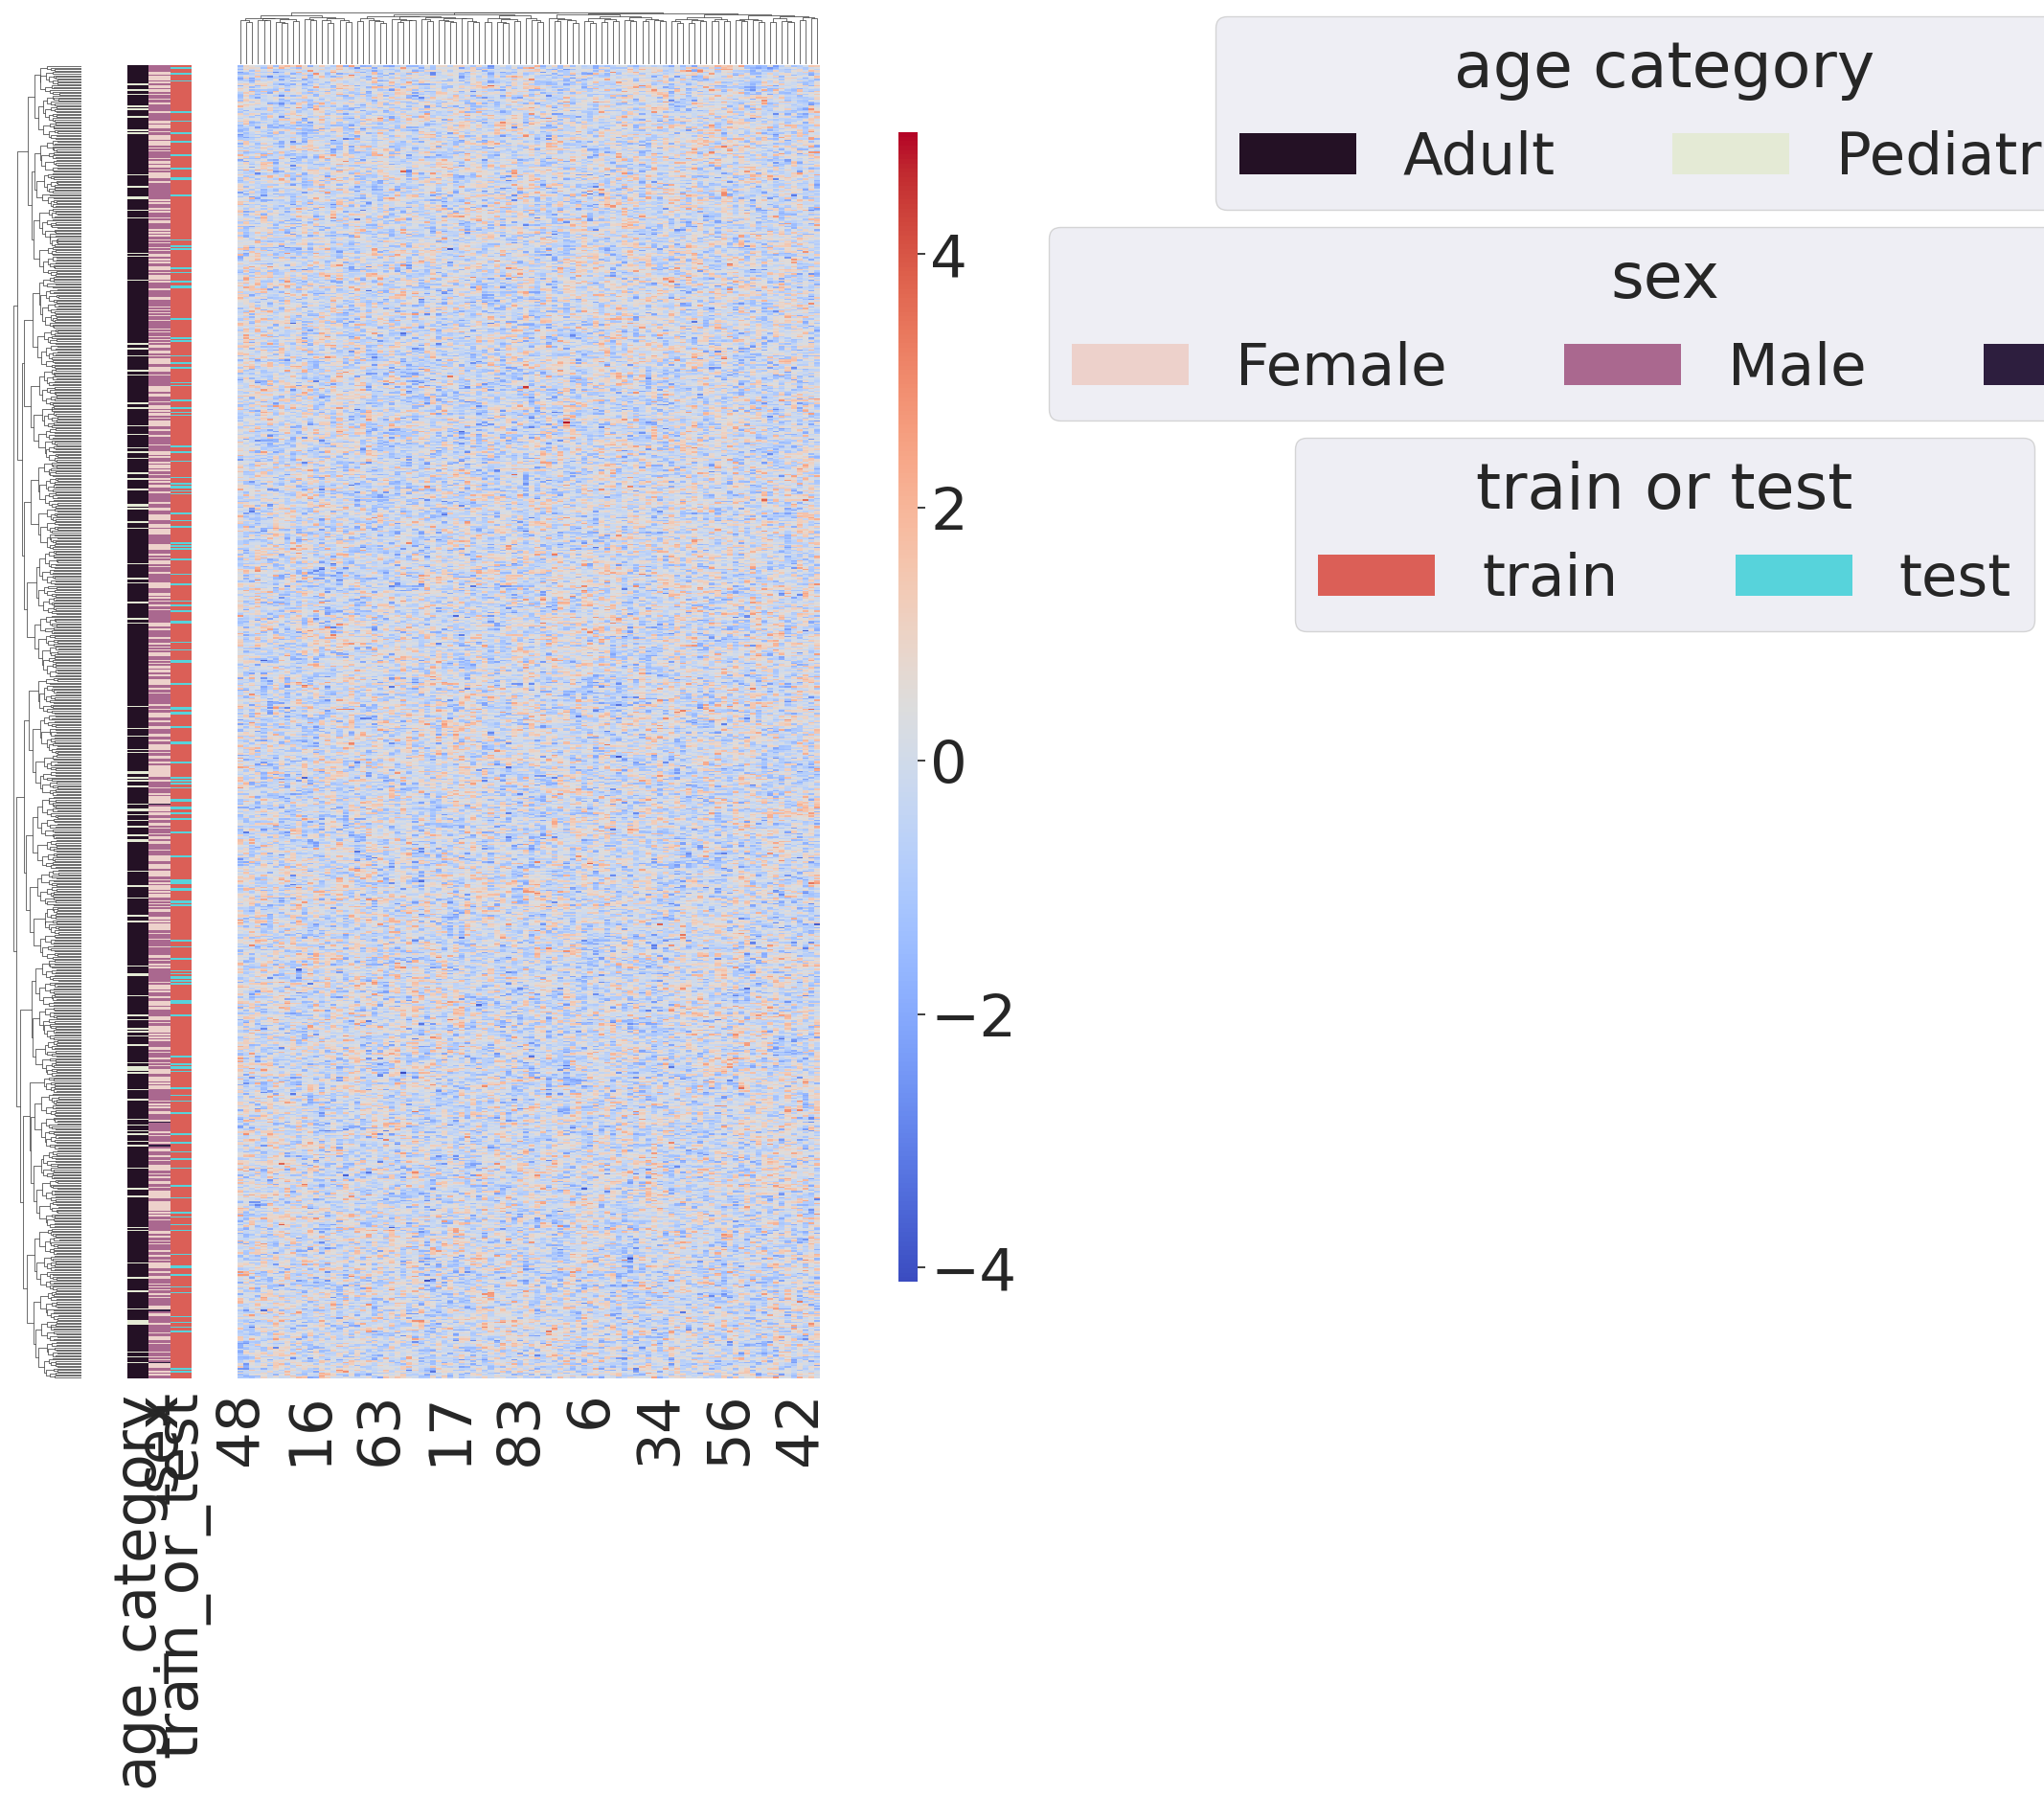

In [10]:
# display clustered heatmap of coefficients
lut_pal = sns.cubehelix_palette(
    age_category.unique().size, light=0.9, dark=0.1, reverse=True, start=1, rot=-2
)
put_pal = sns.cubehelix_palette(sex.unique().size)
mut_pal = sns.color_palette("hls", train_test.unique().size)

lut = dict(zip(age_category.unique(), lut_pal))
put = dict(zip(sex.unique(), put_pal))
mut = dict(zip(train_test.unique(), mut_pal))

row_colors1 = age_category.map(lut)
row_colors2 = sex.map(put)
row_colors3 = train_test.map(mut)

network_node_colors = pd.DataFrame(row_colors1).join(
    pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
)

sns.set(font_scale=4.0)
g = sns.clustermap(
    latent_df.iloc[:,1:],
    method="ward",
    figsize=(10, 20),
    row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
g.ax_row_dendrogram.set_visible(True)
g.ax_col_dendrogram.set_visible(True)


xx = []
for label in age_category.unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
    xx.append(x)
# add the legend
legend3 = plt.legend(
    xx,
    age_category.unique(),
    loc="center",
    title="age category",
    ncol=2,
    bbox_to_anchor=(1.8, 0.91),
    bbox_transform=gcf().transFigure,
)


yy = []
for label in sex.unique():
    y = g.ax_row_dendrogram.bar(0, 0, color=put[label], label=label, linewidth=0)
    yy.append(y)
# add the second legend
legend4 = plt.legend(
    yy,
    sex.unique(),
    loc="center",
    title="sex",
    ncol=3,
    bbox_to_anchor=(1.8, 0.8),
    bbox_transform=gcf().transFigure,
)
plt.gca().add_artist(legend3)


zz = []
for label in train_test.unique():
    z = g.ax_row_dendrogram.bar(0, 0, color=mut[label], label=label, linewidth=0)
    zz.append(z)
# add the third legend
legend5 = plt.legend(
    zz,
    train_test.unique(),
    loc="center",
    title="train or test",
    ncol=2,
    bbox_to_anchor=(1.8, 0.69),
    bbox_transform=gcf().transFigure,
)
plt.gca().add_artist(legend4)


# save the figure
heat_save_path = pathlib.Path("../1.data-exploration/figures/heatmap.png")
plt.savefig(heat_save_path, bbox_inches="tight", dpi=600)

In [11]:
# load the weights dataframe

gene_weights_df = pd.read_csv("../2.train-VAE/results/weight_matrix_encoder.csv")

gene_weights_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.003431,-0.066462,0.023348,-0.087693,-0.035378,-0.130166,-0.011303,0.002215,0.065100,0.010739,...,-0.122327,-0.089983,0.008672,-0.032056,-0.070818,-0.042180,-0.043921,0.070101,-0.021080,-0.009599
1,0.041190,-0.036413,-0.073804,-0.003457,0.214047,0.094045,-0.096939,-0.046628,0.055162,-0.014838,...,0.073669,0.104024,0.006950,0.009301,0.074342,-0.054289,0.122823,-0.103081,-0.096315,0.040273
2,0.042926,-0.047306,-0.007981,0.092379,-0.049409,-0.051858,-0.000272,-0.015936,-0.088256,0.053242,...,-0.071827,-0.009377,0.067449,-0.054565,0.000477,-0.000918,-0.092843,0.085447,-0.072340,0.031898
3,0.025111,-0.041455,-0.056006,0.023690,-0.043088,-0.094552,0.011754,-0.006810,-0.007835,0.055285,...,-0.105212,-0.081106,0.022533,-0.052183,-0.101708,-0.038274,-0.148809,-0.038718,-0.024035,0.003900
4,0.000167,-0.018388,-0.069532,-0.096174,-0.059824,-0.032566,0.070643,0.013985,-0.008484,-0.067908,...,0.083347,0.030248,0.009382,0.011457,-0.023764,-0.003427,-0.043586,-0.049834,-0.042049,0.007481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.067288,-0.143773,-0.143775,0.014089,0.040334,0.089863,-0.017375,-0.021737,-0.118940,0.024656,...,0.064774,-0.013827,-0.100718,-0.074808,-0.039254,-0.095102,0.049255,-0.081385,-0.003753,-0.050191
996,-0.016072,-0.045796,-0.073729,-0.025354,-0.075540,0.056058,-0.039910,-0.028952,-0.066525,0.005927,...,-0.024460,0.054436,0.041238,0.041079,0.012673,-0.045578,0.006619,0.075465,-0.006588,-0.108399
997,0.057418,0.001234,0.052912,0.018644,-0.052687,-0.001355,-0.111365,-0.097282,0.007515,-0.027464,...,-0.043990,0.054211,0.017872,-0.037575,-0.083571,0.084068,-0.045030,-0.086716,0.070513,0.070585
998,0.057376,0.017498,0.054810,-0.024082,0.051792,0.035535,-0.110304,-0.023968,-0.129379,-0.106848,...,-0.004989,-0.028297,0.047371,-0.030608,-0.047045,-0.025918,-0.062715,0.037499,0.037764,0.029140


/home/ecohen/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


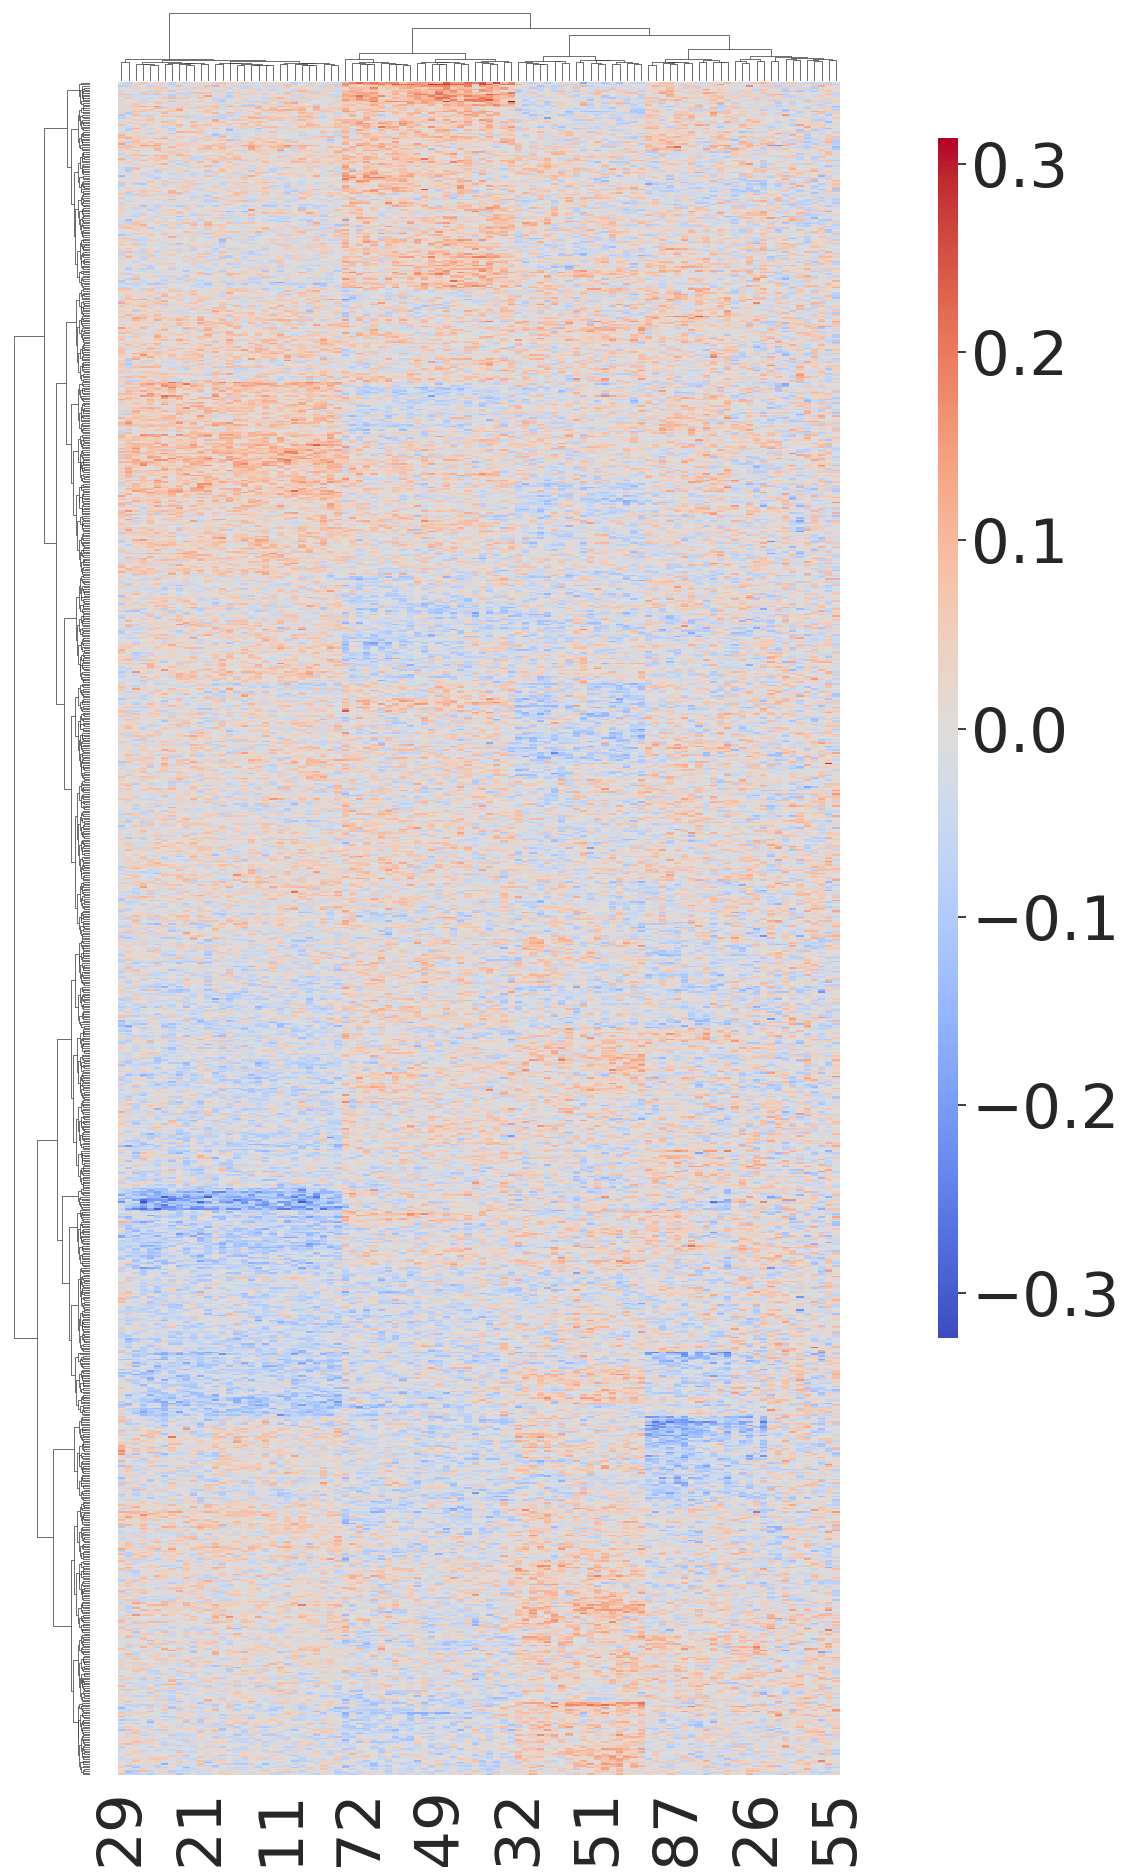

In [12]:
sns.clustermap(
    gene_weights_df,
    method="ward",
    figsize=(10, 20),
    #network_node_colors = pd.DataFrame(row_colors1).join(pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
    #row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
